C:\Users\vigne\Desktop\CW2_PDE4434_Intelligent_Sensing\CW2_PDE4434_Intelligent_Sensing\Dataset\Cards


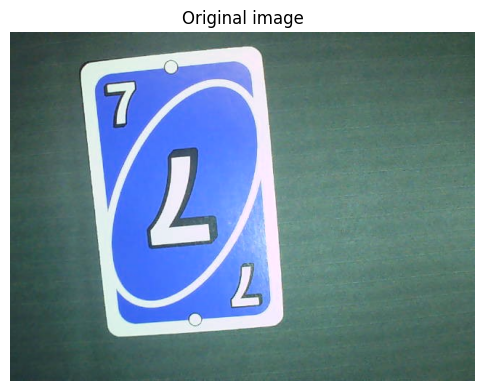

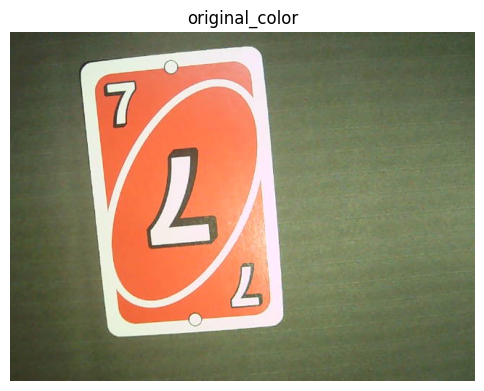

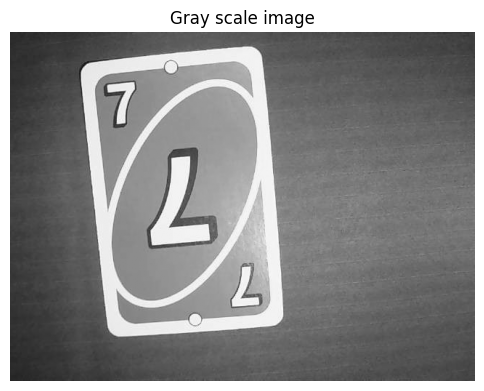

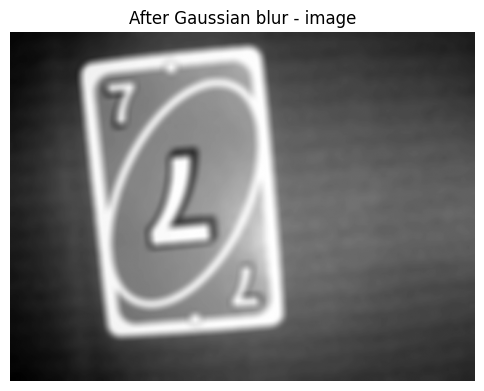

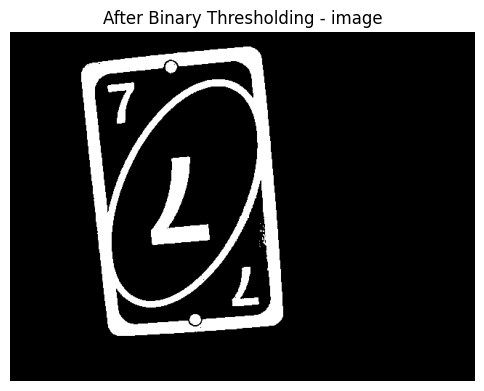

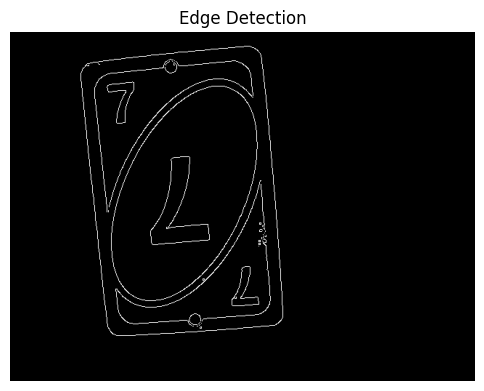

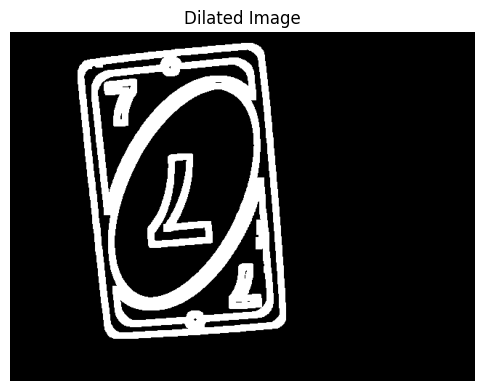

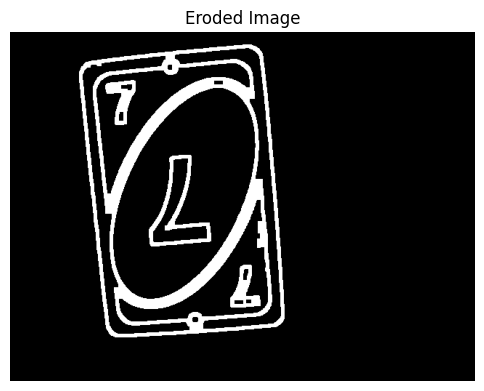

[[ 94  40]
 [345  16]
 [382 401]
 [131 425]]


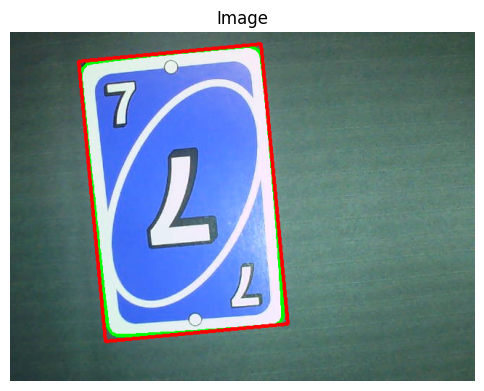

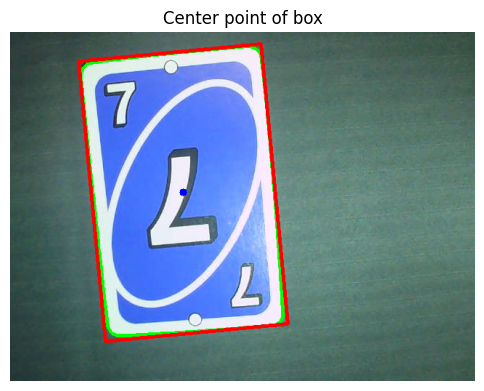

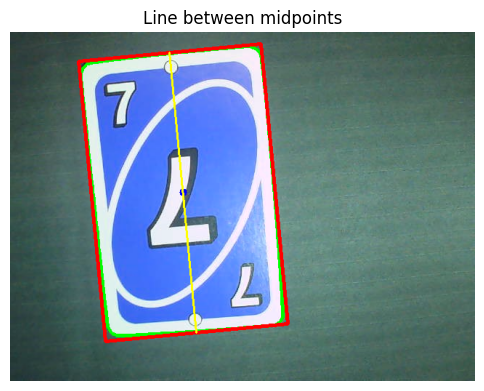

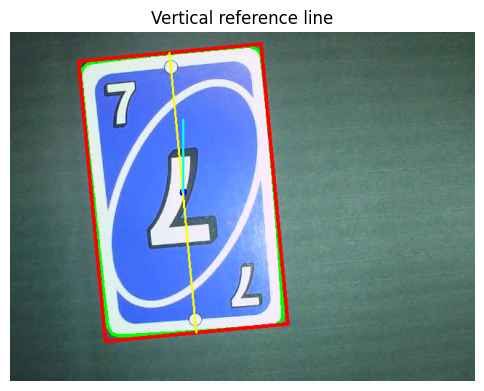

Angle between lines: 174.51 degrees


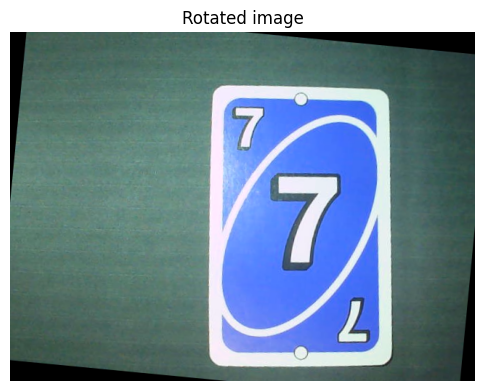

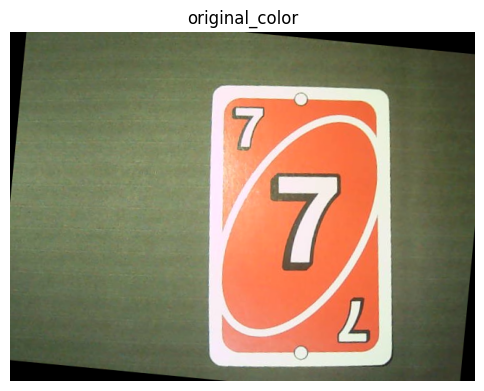

In [8]:
#sample of image preprocessing for nut
import cv2
import numpy as np
import tensorflow as tf
import time
from pathlib import Path
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
import matplotlib.pyplot as plt

def show_image(img, title="Image", cmap=None):
    plt.figure(figsize=(6, 6))
    plt.imshow(img, cmap=cmap)
    plt.title(title)
    plt.axis("off")
    plt.show()

# using current working directory
base_dir = Path.cwd()
Test_dir = base_dir / "Dataset" / "Cards"
print(Test_dir)

test=5
value=str(test)
image = Test_dir / f"{value}.jpg" 

test_image = cv2.imread(image)
copy_image=test_image.copy()
show_image(test_image,"Original image",cmap="grey")

original_color=cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB)
show_image(original_color,"original_color",cmap="grey")


gray = cv2.cvtColor(test_image, cv2.COLOR_BGR2GRAY)
show_image(gray,"Gray scale image",cmap="grey")

blurred = cv2.GaussianBlur(gray, (15, 15), 5)
show_image(blurred,"After Gaussian blur - image",cmap="grey")

_, thresh = cv2.threshold(gray,220, 255, cv2.THRESH_BINARY)
show_image(thresh,"After Binary Thresholding - image",cmap="grey")

edges = cv2.Canny(thresh, 100, 200)
show_image(edges,"Edge Detection",cmap="grey")

kernel = np.ones((5, 5), np.uint8)

dilated = cv2.dilate(edges, kernel, iterations=2)
show_image(dilated,"Dilated Image",cmap="grey")

eroded = cv2.erode(dilated, kernel, iterations=1)
show_image(eroded,"Eroded Image",cmap="grey")

contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cv2.drawContours(test_image, contours, -1, (0, 255, 0), 3)

for contour in contours:
    # Get the minimum area rectangle
    rect = cv2.minAreaRect(contour)
    
    # Get box points
    box = cv2.boxPoints(rect)
    box = box.astype(int)
    print(box)
    # Draw the contour
    cv2.drawContours(test_image, [box], -1, (255, 0, 0), 3)
show_image(test_image)

# Calculate the center of the box
center_x = int(np.mean(box[:, 0]))
center_y = int(np.mean(box[:, 1]))

# Draw the center point
cv2.circle(test_image, (center_x, center_y), 5, (0, 0, 255), -1)  # Red dot at center
show_image(test_image, "Center point of box")

# Assume box points: [pt1, pt2, pt3, pt4]
pt1, pt2, pt3, pt4 = box

# Midpoint of pt1 - pt2
mid1 = ((pt1[0] + pt2[0]) // 2, (pt1[1] + pt2[1]) // 2)

# Midpoint of pt3 - pt4 (opposite side)
mid2 = ((pt3[0] + pt4[0]) // 2, (pt3[1] + pt4[1]) // 2)

# Draw the line between midpoints
cv2.line(test_image, mid1, mid2, (255, 255, 0), 2)  # Light blue line
show_image(test_image, "Line between midpoints")

# Define length of reference line
line_length = 100

# Starting point is center
start_point = (center_x, center_y)

# End point straight up (90 degrees)
end_point = (center_x, center_y - line_length)

# Draw the vertical reference line
cv2.line(test_image, start_point, end_point, (0, 255, 255), 2)  # Yellow line
show_image(test_image, "Vertical reference line")

# Vector of midpoint line
vector_x = mid2[0] - mid1[0]
vector_y = mid2[1] - mid1[1]

# Angle between vector and vertical line (0, -1)
angle_rad = np.arctan2(vector_y, vector_x) - np.arctan2(-1, 0)
angle_deg = np.degrees(angle_rad)
angle_deg = angle_deg % 360  # Ensure positive angle

print(f"Angle between lines: {angle_deg:.2f} degrees")

# Get image center
(h, w) = test_image.shape[:2]
image_center = (w // 2, h // 2)

# Compute rotation matrix
M = cv2.getRotationMatrix2D(image_center, angle_deg, 1.0)

# Perform the rotation
rotated = cv2.warpAffine(copy_image, M, (w, h))
show_image(rotated, "Rotated image")

#cycle2

cycle2_original=cv2.cvtColor(rotated, cv2.COLOR_BGR2RGB)
show_image(cycle2_original,"original_color",cmap="grey")
        

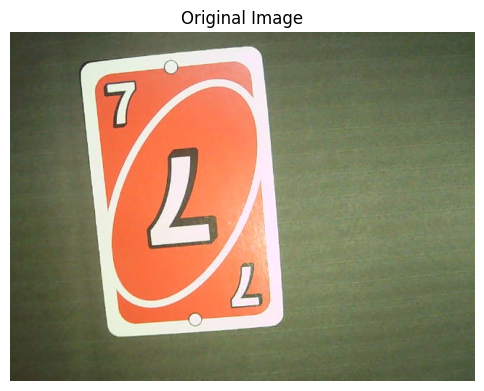

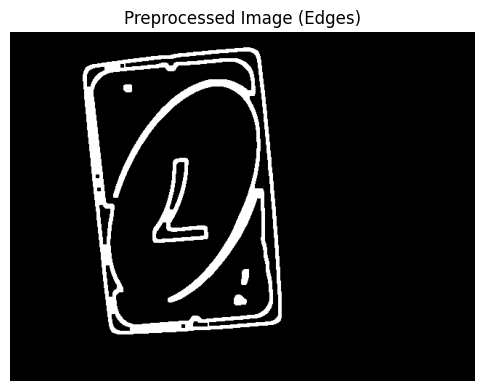

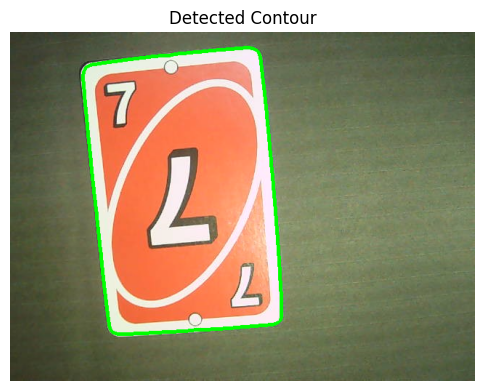

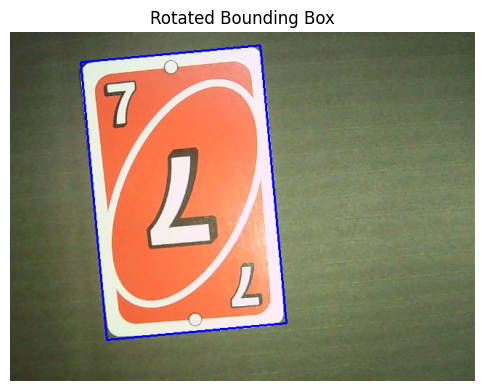

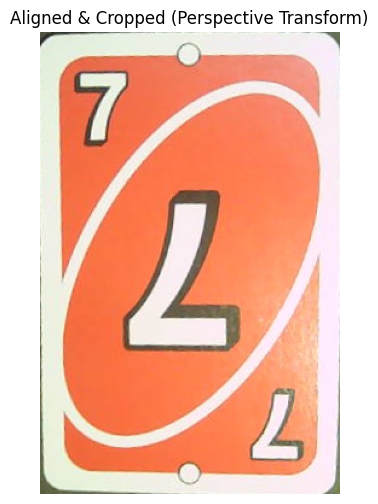

In [3]:
import cv2
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

# Utility function to display images
def show_image(image, title="", cmap="gray"):
    plt.figure(figsize=(6, 6))
    if len(image.shape) == 2:
        plt.imshow(image, cmap=cmap)
    else:
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.axis("off")
    plt.show()

# Utility function to order points for perspective transform
def order_points(pts):
    # Initial ordering: top-left, top-right, bottom-right, bottom-left
    rect = np.zeros((4, 2), dtype="float32")
    s = pts.sum(axis=1)
    diff = np.diff(pts, axis=1)

    rect[0] = pts[np.argmin(s)]  # top-left
    rect[2] = pts[np.argmax(s)]  # bottom-right
    rect[1] = pts[np.argmin(diff)]  # top-right
    rect[3] = pts[np.argmax(diff)]  # bottom-left

    return rect

# Function to perform four-point perspective transform
def four_point_transform(image, pts):
    rect = order_points(pts)
    (tl, tr, br, bl) = rect

    # Compute width and height of the new image
    widthA = np.linalg.norm(br - bl)
    widthB = np.linalg.norm(tr - tl)
    maxWidth = int(max(widthA, widthB))

    heightA = np.linalg.norm(tr - br)
    heightB = np.linalg.norm(tl - bl)
    maxHeight = int(max(heightA, heightB))

    # Destination points for top-down view
    dst = np.array([
        [0, 0],
        [maxWidth - 1, 0],
        [maxWidth - 1, maxHeight - 1],
        [0, maxHeight - 1]], dtype="float32")

    # Compute perspective transform matrix and apply it
    M = cv2.getPerspectiveTransform(rect, dst)
    warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight))

    return warped

# === MAIN PROCESS === #

# Set paths
base_dir = Path.cwd()
Test_dir = base_dir / "Dataset" / "Cards"
test_image_num = 5
image_path = Test_dir / f"{test_image_num}.jpg"

# Load image
image = cv2.imread(str(image_path))
if image is None:
    raise FileNotFoundError(f"Image not found at path: {image_path}")

show_image(image, "Original Image")

# Preprocessing
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
blurred = cv2.GaussianBlur(gray, (15, 15), 5)
_, thresh = cv2.threshold(blurred, 220, 255, cv2.THRESH_BINARY)
edges = cv2.Canny(thresh, 100, 200)

kernel = np.ones((5, 5), np.uint8)
dilated = cv2.dilate(edges, kernel, iterations=2)
eroded = cv2.erode(dilated, kernel, iterations=1)

show_image(eroded, "Preprocessed Image (Edges)")

# Contour detection
contours, _ = cv2.findContours(eroded, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

if contours:
    # Get the largest contour
    largest_contour = max(contours, key=cv2.contourArea)

    # Draw detected contour
    contour_image = image.copy()
    cv2.drawContours(contour_image, [largest_contour], -1, (0, 255, 0), 3)
    show_image(contour_image, "Detected Contour")

    # Get min area rectangle
    rect = cv2.minAreaRect(largest_contour)
    box = cv2.boxPoints(rect)
    
    box = np.array(box, dtype="int")

    # Draw rectangle for reference
    rectangle_image = image.copy()
    cv2.drawContours(rectangle_image, [box], -1, (255, 0, 0), 2)
    show_image(rectangle_image, "Rotated Bounding Box")

    # Apply four-point perspective transform
    warped = four_point_transform(image, box)
    show_image(warped, "Aligned & Cropped (Perspective Transform)")

    """# Optional: Save the aligned image for dataset
    output_dir = base_dir / "Processed"
    output_dir.mkdir(parents=True, exist_ok=True)
    output_path = output_dir / f"processed_{test_image_num}.jpg"
    cv2.imwrite(str(output_path), warped)
    print(f"Processed image saved at: {output_path}")
    """
else:
    print("No contours found!")



C:\Users\vigne\Desktop\CW2_PDE4434_Intelligent_Sensing\CW2_PDE4434_Intelligent_Sensing\Dataset\Cards


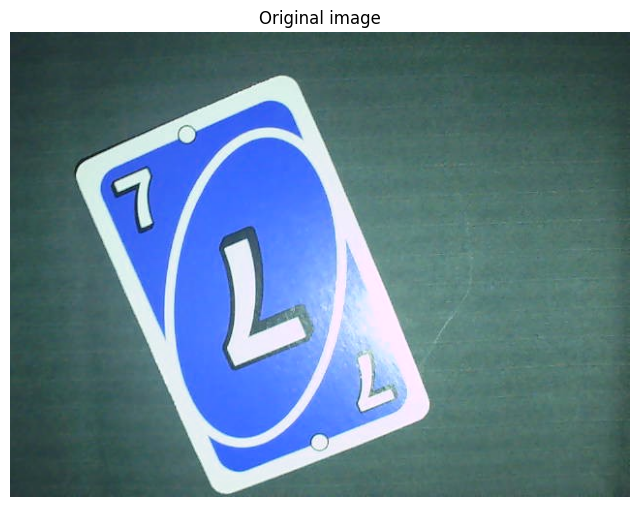

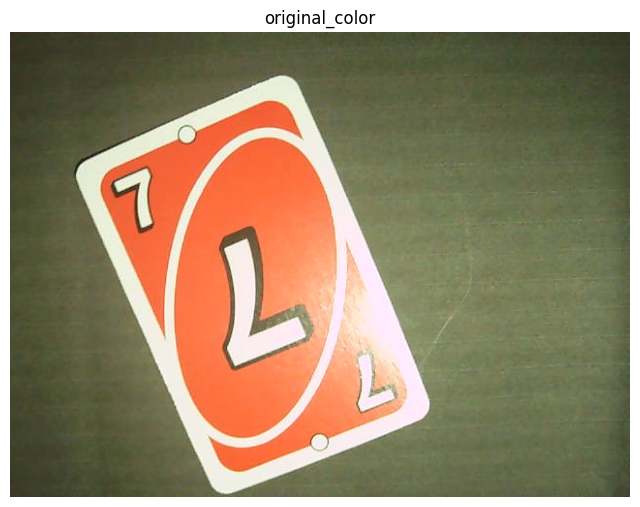

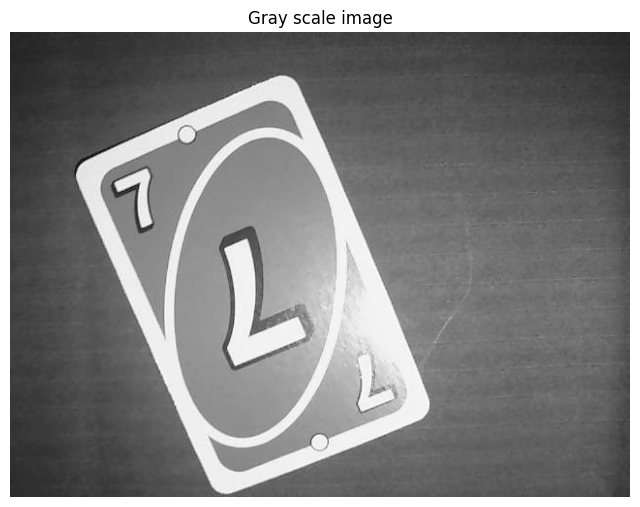

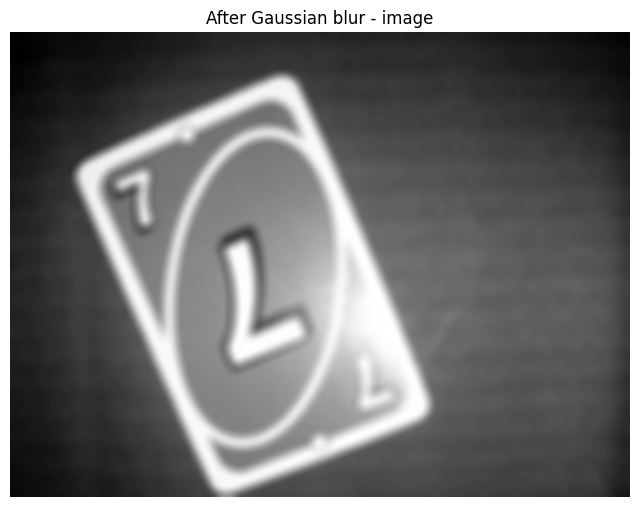

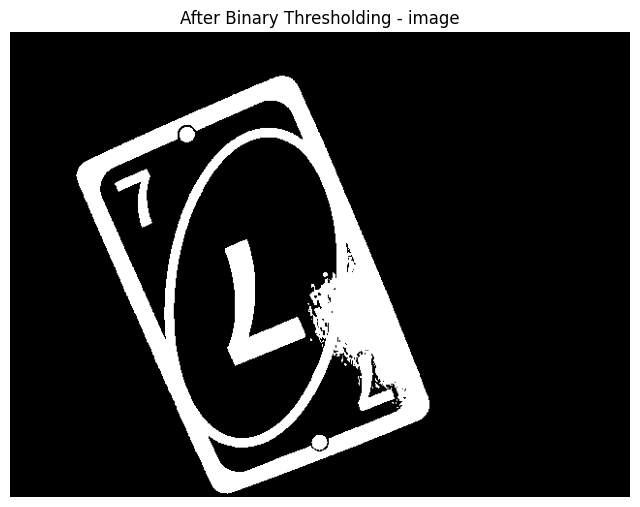

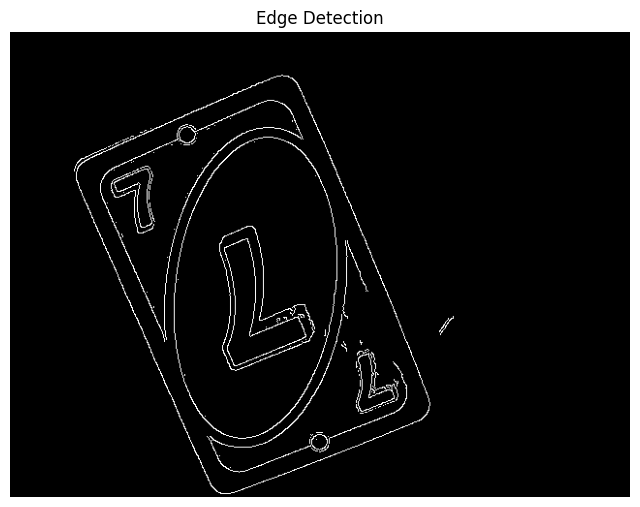

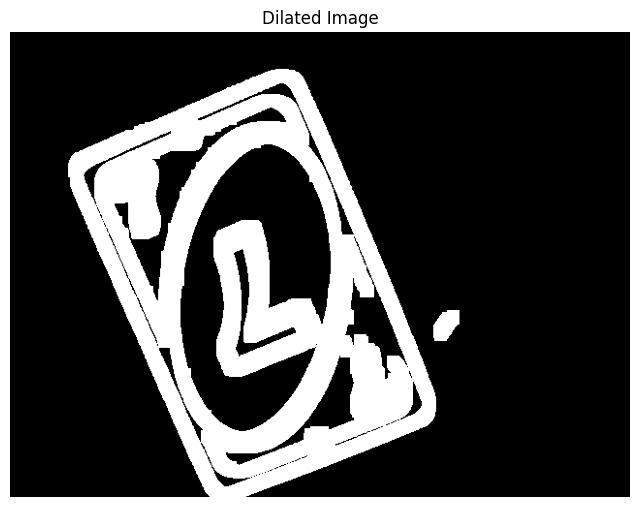

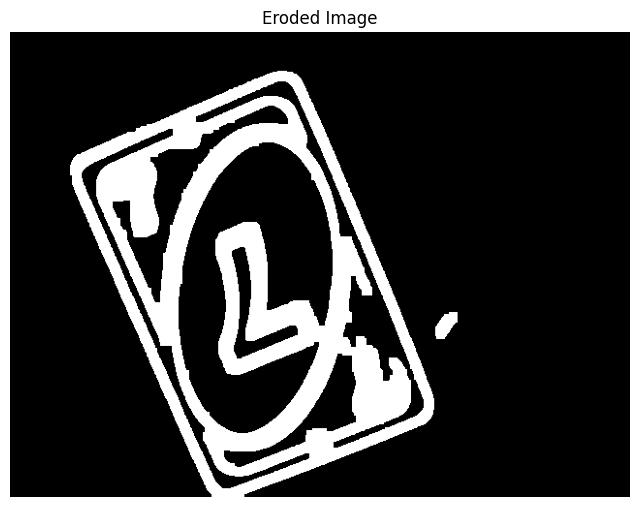

[[ 60 136]
 [290  36]
 [444 391]
 [214 491]]


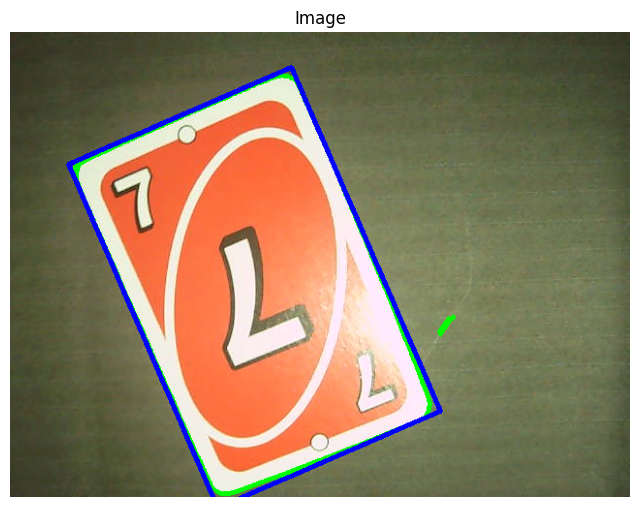

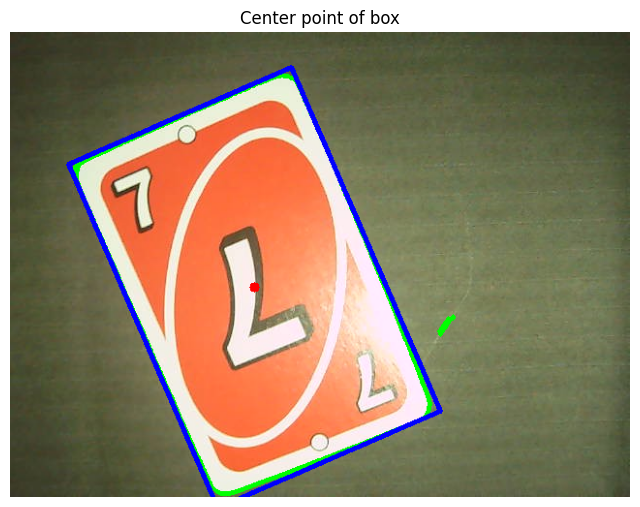

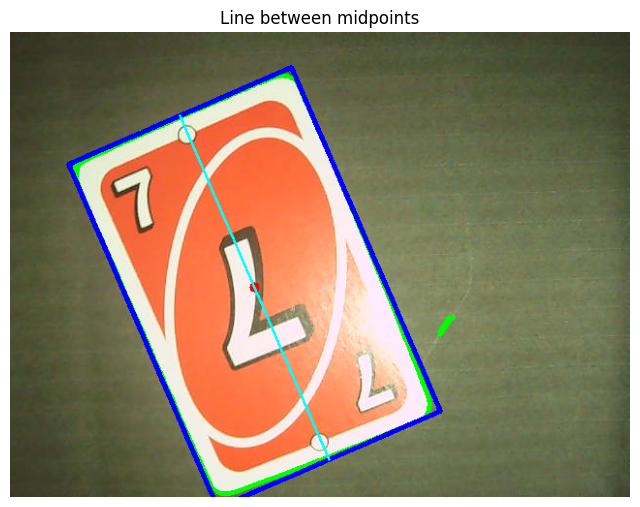

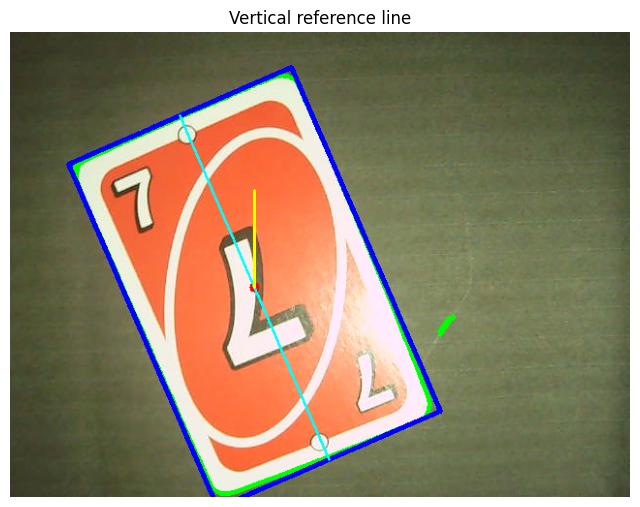

Angle between lines: 156.55 degrees


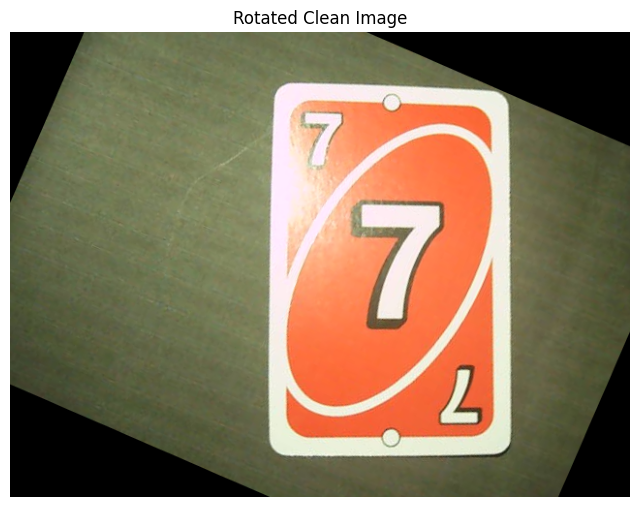

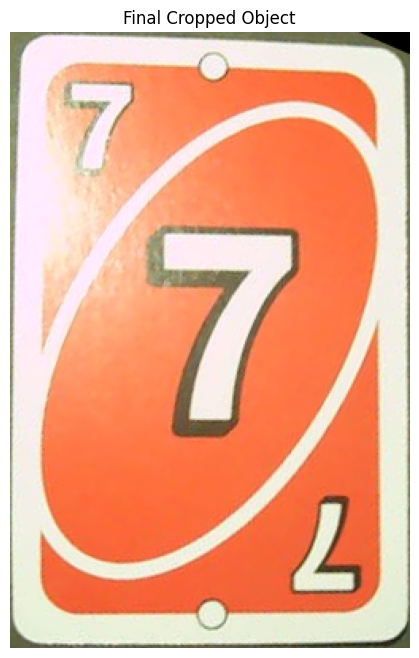

In [28]:
import cv2
import numpy as np
import time
from pathlib import Path
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

def show_image(image, title="Image", cmap=None):
    import matplotlib.pyplot as plt
    plt.figure(figsize=(8, 8))
    if cmap:
        plt.imshow(image, cmap=cmap)
    else:
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.axis('off')
    plt.show()

# Using current working directory
base_dir = Path.cwd()
Test_dir = base_dir / "Dataset" / "Cards"
print(Test_dir)

test = 8
value = str(test)
image = Test_dir / f"{value}.jpg"

test_image = cv2.imread(str(image))
clean_image = test_image.copy()  # Save clean copy before drawing
show_image(test_image, "Original image", cmap="grey")

original_color = cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB)
show_image(original_color, "original_color", cmap="grey")

gray = cv2.cvtColor(test_image, cv2.COLOR_BGR2GRAY)
show_image(gray, "Gray scale image", cmap="grey")

blurred = cv2.GaussianBlur(gray, (15, 15), 5)
show_image(blurred, "After Gaussian blur - image", cmap="grey")

_, thresh = cv2.threshold(gray, 200, 255, cv2.THRESH_BINARY)
show_image(thresh, "After Binary Thresholding - image", cmap="grey")

edges = cv2.Canny(thresh, 100, 200)
show_image(edges, "Edge Detection", cmap="grey")

kernel = np.ones((5, 5), np.uint8)

dilated = cv2.dilate(edges, kernel, iterations=3)
show_image(dilated, "Dilated Image", cmap="grey")

eroded = cv2.erode(dilated, kernel, iterations=1)
show_image(eroded, "Eroded Image", cmap="grey")

contours, _ = cv2.findContours(eroded, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cv2.drawContours(test_image, contours, -1, (0, 255, 0), 3)

# Use the largest contour
contour = max(contours, key=cv2.contourArea)

# Get the minimum area rectangle
rect = cv2.minAreaRect(contour)

# Get box points
box = cv2.boxPoints(rect)
box = box.astype(int)
print(box)

# Draw the contour (only on drawing image)
cv2.drawContours(test_image, [box], -1, (255, 0, 0), 3)
show_image(test_image)

# Calculate the center of the box
center_x = int(np.mean(box[:, 0]))
center_y = int(np.mean(box[:, 1]))

# Draw the center point
cv2.circle(test_image, (center_x, center_y), 5, (0, 0, 255), -1)  # Red dot at center
show_image(test_image, "Center point of box")

# Assume box points: [pt1, pt2, pt3, pt4]
pt1, pt2, pt3, pt4 = box

# Midpoint of pt1 - pt2
mid1 = ((pt1[0] + pt2[0]) // 2, (pt1[1] + pt2[1]) // 2)

# Midpoint of pt3 - pt4 (opposite side)
mid2 = ((pt3[0] + pt4[0]) // 2, (pt3[1] + pt4[1]) // 2)

# Draw the line between midpoints
cv2.line(test_image, mid1, mid2, (255, 255, 0), 2)  # Light blue line
show_image(test_image, "Line between midpoints")

# Define length of reference line
line_length = 100

# Starting point is center
start_point = (center_x, center_y)

# End point straight up (90 degrees)
end_point = (center_x, center_y - line_length)

# Draw the vertical reference line
cv2.line(test_image, start_point, end_point, (0, 255, 255), 2)  # Yellow line
show_image(test_image, "Vertical reference line")

# Vector of midpoint line
vector_x = mid2[0] - mid1[0]
vector_y = mid2[1] - mid1[1]

# Angle between vector and vertical line (0, -1)
angle_rad = np.arctan2(vector_y, vector_x) - np.arctan2(-1, 0)
angle_deg = np.degrees(angle_rad)
angle_deg = angle_deg % 360  # Ensure positive angle

print(f"Angle between lines: {angle_deg:.2f} degrees")

# Get image center
(h, w) = test_image.shape[:2]
image_center = (w // 2, h // 2)

# Compute rotation matrix
M = cv2.getRotationMatrix2D(image_center, angle_deg, 1.0)

# Perform rotation on clean image (no drawings!)
rotated_clean = cv2.warpAffine(clean_image, M, (w, h))
show_image(rotated_clean, "Rotated Clean Image")

# Rotate the box points to get crop region
box_points = np.array(box, dtype=np.float32)
ones = np.ones(shape=(len(box_points), 1))
points_ones = np.hstack([box_points, ones])

rotated_points = M.dot(points_ones.T).T

# Get bounding rectangle of rotated points
x, y, w_crop, h_crop = cv2.boundingRect(np.int32(rotated_points))

# Crop the rotated clean image
cropped = rotated_clean[y:y+h_crop, x:x+w_crop]
show_image(cropped, "Final Cropped Object")
